# Описание, заметки, размышления

Для прогнозирования используются данные о покупках юзеров за период 2021 года. Всего доступно больше 2 млн. строк.

Флаг оттока проставляется, если после покупки юзера прошло больше 45 дней.

Поведение юзера описывается историей его покупок, суммой чека и размером скидки к чеку. В компании действует программа лояльности, участвуя в которой юзеры получают скидку на любую покупку и могут получать дополнительные скидки по разным промо-акциями.

Описание данных:
data.csv
* `'clnt_ID'` - уникальный айди юзера, str
* `'timestamp'` - дата и время совершения покупки, datetime
* `'gest_Sum'` - сумма покупки, float
* `'gest_Discount'` - сумма скидки, float

target.csv
* `'clnt_ID'` - уникальный айди юзера, str
* `'target'` - флаг оттока, int: 1 если юзер ушел в отток | 0 если НЕ отток

Это задача бинарной классификации. Используем метрику: `roc auc`.

<!-- ## Что здесь можно сделать? - Заметки 
**Нужно помнить, что по сути это тайм серия.**  -- **Внимательно!**  
Т.е. я предполагаю, что клиент покупает, покупает, покупает, потом фигак и перестал покупать. Один клиент - один вектор.
А тут куча вектором принадлежат одному клиенту. 

Т.е. я бы даже сказал, что в том виде в котором оно есть, модель особо-то ничего не найдет. Как она сможет по дате, сумме покупки и скидке предсказать уйдет человек или нет, не зная его истории?
---ОТВЕТ---
Да, это последовательность событий, но прям как таймсерию использовать не можем, потому что нерегулярные сигналы и из-за этого много сложностей.
Но! Можно использовать эти же строки, но к ним добавлять "память" о клиенте, т.е. его историю к конкретной сделке.

**Что может говорить, что клиент собрался уйти и не вернуться?**  
Т.е. гипотетически что может говорить о том, что клиент собирается уйти и не вернуться?
1. Увеличивается интервал между покупками от покупки к покупке. Типа 1 день, потом 2, потом 5 и т.д.
2. Как-то изменяется объем чека (уменьшается, увеличивается?) 
3. Как-то меняется ассортимент (типа вот он покупал одно и тоже, а тут вдруг перестал покупать одно и тоже (испортился товар на его вкус) и он либо сразу ушел, либо попробовал другое и остался, либо попробовал другое - ему не понравилось - ушел

**Как должен работать предикт? Какие данные должны поступать на вход?**  -- **Есть пол-ответа**  
~~Это видимо тоже относится к тому, что это своего рода таймсерия~~
Вся инфа находится в БД, которая обновляется ночью. И модель будет работать ночью и может использовать всю бд. Как именно пока я не понимаю.


**Если сейчас дать модели на вход просто дату, сумму чека и скидку...**  
То она будет пытаться предсказать отток исключительно по дате, сумме чеку и скидке - врядли у нее что-то получится взразумительное.


**Сумма в месяц стабильна для юзера, а отклонение может указывать на отток**  
По результатам уже проведенного анализа есть такой вывод:
сумма, которую готов тратить юзер в месяц,  достаточна стабильна и слабо меняется со временем. Потратив в этом месяце больше обычного, юзер скорее всего в следующем не будет покупать;

По каждому клиенту взять средний чек, каким-то образом определить порог отклонения от этого среднего чека и посмотреть насколько факт этого отклонения коррелирует с оттоком. Может это будет хорошая фича. Но проблема в том, что для предсказания не достаточно 

**Самый простой и очевидный способ подготовки данных**  
Это взять по каждому клиенту кол-во покупок, min,max,mean,median,stdev по gest_Sum, gest_Discount, и перерывом между покупками

**Вариант еще лучше!**  
Используем каждую строку как есть, не переводим ее в строку по уникальному клиенту, а точно также одна строка одна сделка.
К каждой такой строке мы накопительно добавляем кумулятивную инфу о клиенте, т.е.:
* Сколько дней на момент сделки прошло с момента первой сделки
* Какой на текущий момент средний чек
* Какая разница между среднем чеком и чеком сделки
* Сколько сделок произошло на момент текущей сделки
* Сколько сделок в месяц в среднем



## Вопросы:
**>>>Что значат 0 в gest_sum?<<<**

**Как работают скидки? Это накопительные баллы или просто скидки? Почему основные скидки не больше 100 руб, но бывают аж в 3000 руб.?** -->

Структура:  

0. Описание, заметки, размышления
1. Импорты и настройки
2. Предобработка
3. EDA
4. Feature engineering
5. Baseline and model selection
6. Model tuning

# Импорты и настройки

In [1]:
import warnings

import numpy as np
import pandas as pd

import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns

# from pandas_profiling import ProfileReport

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from catboost import CatBoostClassifier, Pool

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

from sklearn.metrics import f1_score


In [2]:
# Настройки pandas
# pd.set_option('display.max_rows', 100)
pd.options.display.float_format = '{:.3f}'.format

In [3]:
# np set random seed
rand_state = 777
# rng = np.random.default_rng(rand_state)

# Предобработка

In [4]:
df = pd.read_csv('data/data.csv', parse_dates=[1])
df_target = pd.read_csv('data/target.csv')

In [5]:
display(df.head())
df_target.head()

,clnt_ID,timestamp,gest_Sum,gest_Discount
0,193B4268-0B4A-475E-B1D0-FF5515E29D29,2021-01-02 09:09:17.060,900.000,300.000
1,8DA65A37-C1D0-41D4-98E1-AB6C5BF1367F,2021-01-02 09:12:24.850,165.000,55.000
2,26ACF3C8-25C8-4345-ABC2-33DA15EA6454,2021-01-02 09:38:21.643,800.500,25.500
3,0F77DDB3-A9A7-44BE-AAAB-9DF59B66A695,2021-01-02 09:45:17.793,580.000,0.000
4,F16BCF77-FA5A-4093-B7E3-FA86E2B1EA31,2021-01-02 09:59:50.453,148.900,3.100


,clnt_ID,target
0,000070A8-DB9E-4AB7-8C4D-6169D4AEBB2A,1
1,00007EB0-6331-438E-A917-E9840C260876,0
2,0000993D-A30E-4233-AB3F-D368D9A0D2C4,1
3,0000A724-7BC5-408F-9F16-6CC3AB16322F,0
4,0000B90C-56DE-43C2-A213-624AFBE36DB2,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2371635 entries, 0 to 2371634
Data columns (total 4 columns):
 #   Column         Dtype         
---  ------         -----         
 0   clnt_ID        object        
 1   timestamp      datetime64[ns]
 2   gest_Sum       float64       
 3   gest_Discount  float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 72.4+ MB


In [7]:
df_target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255109 entries, 0 to 255108
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   clnt_ID  255109 non-null  object
 1   target   255109 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.9+ MB


In [8]:
# Изменим тип данных в timestamp на datetime
# df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y-%m-%d %H:%M:%S.%f')
# Добавим столбец с только датой.
# df['date'] = df['timestamp'].dt.date

Проверим на дубликаты и пропуски.

In [9]:
df.isna().sum()

clnt_ID          0
timestamp        0
gest_Sum         0
gest_Discount    0
dtype: int64

Пропусков нет.

In [10]:
df.duplicated().sum()

129

Есть дубликаты, посмотрим на них.

In [11]:
df.loc[df.duplicated(keep=False)]

,clnt_ID,timestamp,gest_Sum,gest_Discount
639,1FA367BD-8E07-437E-AB6A-009D53533128,2021-01-02 12:00:00,982.200,0.000
663,1FA367BD-8E07-437E-AB6A-009D53533128,2021-01-02 12:00:00,982.200,0.000
85786,3319362D-F6AD-498B-9B53-F59D0418915E,2021-01-14 14:00:00,1189.000,0.000
85787,3319362D-F6AD-498B-9B53-F59D0418915E,2021-01-14 14:00:00,1189.000,0.000
133279,A145C6F8-EDCB-47B1-BF5D-B328F6AF97CA,2021-01-20 16:00:00,0.000,0.000
...,...,...,...,...
2165277,E99EFF35-01BE-49A9-8F61-641F752051E5,2021-11-08 15:00:00,0.000,0.000
2174627,1A4C0239-A7AB-4188-84DB-8F52FBF6E13C,2021-11-10 11:00:00,282.240,37.760
2174629,1A4C0239-A7AB-4188-84DB-8F52FBF6E13C,2021-11-10 11:00:00,282.240,37.760
2198034,C9D86AF9-373C-4531-92A4-8FC752DD5D75,2021-11-14 12:00:00,0.000,0.000


Удалим дубликаты.

In [12]:
df = df.drop_duplicates()

In [13]:
df.duplicated().sum()

0

Дубликаты удалили.

# EDA

Вопросы к данным?
1. Действительно ли таргет 1 там, где дельта между датами покупки >= 45 дней?
2. Есть ли дисбаланс классов (по сделкам и по клиентам)
3. Есть ли какие-то аномалии (неожиданные значения) в 
    * датах,
    * сумме чека за вычетом скидки
    * в размере скидки

Сравнение по таргету:
4. Отличаются ли клиенты, которые ушли в отток от тех, которые не ушли по:
    * чеку за вычетом скидки, 
    * по скидке, 
    * по общей стоимости (без учета скидки), 
    * по длительности в днях между покупками
    
5. Корреляции в данных по сделкам и по клиентам


## Проверка таргета

**Действительно ли таргет 1 там, где дельта между датами покупки >= 45 дней?**  
Для этого создадим соответствующее условие, применим его к данным со сделками и сравним в таргетом.
1. Создадим фичу с дельтой в днях между покупками по каждому клиенту
2. Проверим, если максимальная дельта у клиента больше или равна 45 дням, то ставим флаг 1, в противном случае 0.
3. Сравниваем получившиеся флаги с предоставленными данными по таргету.

In [14]:
# Создаем фичу с дельтой в днях между покупками по каждому клиенту
def time_delta(col):
    return col.diff()

df['days_after_last_buy'] = df.groupby('clnt_ID')['timestamp'].transform(time_delta)
df['days_after_last_buy'] = df['days_after_last_buy'].dt.days
df['days_after_last_buy'] = df['days_after_last_buy'].fillna(-1) # Это делаем, чтобы значение "вообще не было покупок ранее" отличалось от "прошло 0 дней с прошлой покупки"

In [15]:
df.head()

,clnt_ID,timestamp,gest_Sum,gest_Discount,days_after_last_buy
0,193B4268-0B4A-475E-B1D0-FF5515E29D29,2021-01-02 09:09:17.060,900.000,300.000,-1.000
1,8DA65A37-C1D0-41D4-98E1-AB6C5BF1367F,2021-01-02 09:12:24.850,165.000,55.000,-1.000
2,26ACF3C8-25C8-4345-ABC2-33DA15EA6454,2021-01-02 09:38:21.643,800.500,25.500,-1.000
3,0F77DDB3-A9A7-44BE-AAAB-9DF59B66A695,2021-01-02 09:45:17.793,580.000,0.000,-1.000
4,F16BCF77-FA5A-4093-B7E3-FA86E2B1EA31,2021-01-02 09:59:50.453,148.900,3.100,-1.000


In [16]:
df.tail()

,clnt_ID,timestamp,gest_Sum,gest_Discount,days_after_last_buy
2371630,6A41E569-CE78-47F3-A671-357000336B67,2021-12-15 22:27:59.033,630.000,210.000,0.000
2371631,9ABC36A1-BA7D-4145-A25B-609945E1B50F,2021-12-15 22:34:49.327,76.000,19.000,0.000
2371632,565D07CD-6B1C-4F17-988E-313C2E5C6798,2021-12-15 22:42:54.540,346.400,153.600,7.000
2371633,F9953B4A-FADB-4213-82EB-6E2B7D1565C7,2021-12-15 22:44:54.387,52.500,17.500,0.000
2371634,6E719B78-61E2-4F03-BF63-D83AE5DE5629,2021-12-15 22:45:31.087,661.600,43.400,1.000


In [17]:
# Проверим равна или больше 45 кол-во дней с прошлой покупки по каждому клиенту

# Сгруппируем данные
df_eda_temp = df.pivot_table(index='clnt_ID',values=['days_after_last_buy'],aggfunc='max')
df_eda_temp

,days_after_last_buy
clnt_ID,
000070A8-DB9E-4AB7-8C4D-6169D4AEBB2A,28.000
00007EB0-6331-438E-A917-E9840C260876,-1.000
0000993D-A30E-4233-AB3F-D368D9A0D2C4,-1.000
0000A724-7BC5-408F-9F16-6CC3AB16322F,40.000
0000B90C-56DE-43C2-A213-624AFBE36DB2,-1.000
...,...
FFFF1629-85B6-9DD3-994C-5E21A88A5BFF,-1.000
FFFF364C-972B-4F77-9A75-AF62F01E6B7B,-1.000
FFFF3BC7-D0FB-4630-8D09-1D4088C5A297,10.000


In [18]:
# Создадим столбец с условием
df_eda_temp['>=45'] = df_eda_temp['days_after_last_buy'] >= 45

In [19]:
df_eda_temp

,days_after_last_buy,>=45
clnt_ID,,
000070A8-DB9E-4AB7-8C4D-6169D4AEBB2A,28.000,False
00007EB0-6331-438E-A917-E9840C260876,-1.000,False
0000993D-A30E-4233-AB3F-D368D9A0D2C4,-1.000,False
0000A724-7BC5-408F-9F16-6CC3AB16322F,40.000,False
0000B90C-56DE-43C2-A213-624AFBE36DB2,-1.000,False
...,...,...
FFFF1629-85B6-9DD3-994C-5E21A88A5BFF,-1.000,False
FFFF364C-972B-4F77-9A75-AF62F01E6B7B,-1.000,False
FFFF3BC7-D0FB-4630-8D09-1D4088C5A297,10.000,False


In [20]:
# Посмотрим что получилось
display(df_eda_temp['>=45'].describe())
df_eda_temp['>=45'].value_counts()

count     255109
unique         2
top        False
freq      250480
Name: >=45, dtype: object

False    250480
True       4629
Name: >=45, dtype: int64

In [21]:
# Посмотрим и сравним с таргетом, который был даден заказчиком
df_target['target'].value_counts()

0    128857
1    126252
Name: target, dtype: int64

На лицо очень сильная разница:  
В моем скрипте в оттоке 4629 (True),  
В предоставленных данных 126252.

In [22]:
# df_eda_temp['>=45'].to_csv('data/target_generated_on_data.csv')

In [23]:
df_target_extracted = df_eda_temp['>=45'].astype('int8')
df_target_extracted.name = 'target_ext'

**Есть ли дисбаланс классов?**

Посмотрим по новым и старым таргетам.

In [24]:
print('Таргет по клиентам, старый таргет')
display(df_target['target'].value_counts())
print()
# Проверим дисбаланс по таргету на сделках
print('Таргет по сделкам, старый таргет')
df.merge(df_target,on='clnt_ID')['target'].value_counts()

Таргет по клиентам, старый таргет


0    128857
1    126252
Name: target, dtype: int64


Таргет по сделкам, старый таргет


0    1699701
1     671805
Name: target, dtype: int64

Дисбаланса по клиентам *нет*(*?*).  
Дисбаланс по сделкам *есть*(*?*).

In [25]:
print('Таргет по клиентам, новый таргет')
display(pd.concat([df_target_extracted.value_counts(normalize=True),df_target_extracted.value_counts()],axis=1))
print()
print('Таргет по сделкам, новый таргет')
df.merge(df_target_extracted,on='clnt_ID')['target_ext'].value_counts()

Таргет по клиентам, новый таргет


,target_ext,target_ext
0,0.982,250480
1,0.018,4629



Таргет по сделкам, новый таргет


0    2339855
1      31651
Name: target_ext, dtype: int64

Дисбаланс по новому таргету по клиентам есть.  
Дисбаланс по новому таргету по сделкам тож есть.

## Поиск аномалий в данных

Для поиска аномалий воспользуемся собственной функцией подсчета статистик числовых признаков (но не даты).

In [26]:
def describe(col):
    """
    Функция выводит подробное числовое описание данных.
    """

#     Подсчет количества значений
    count_ = col.count()
    
#     Меры центральной тенденции:
#     Среднее
    mean = col.mean()
#     Медиана
    median = col.median()
#     Мода
    mode = col.mode()

#     Меры разброса
#     Дисперсия
    var = col.var()
#     Стандартное отклонение
    stddev = col.std()
#     Межквартильный размах
    quartile_1 = col.quantile(0.25)
    quartile_3 = col.quantile(0.75)
    iqr = quartile_3 - quartile_1
#     Мин, макс, размах
    min_ = col.min()
    max_ = col.max()
    range_ = max_ - min_

#     Левая граница ящика с усами
    outlier_border_left = quartile_1 - 1.5 * iqr
#     Правая граница ящика с усами
    outlier_border_right = quartile_3 + 1.5 * iqr
    
#    Количество выбросов
    outliers_mask = (col <= outlier_border_left) | (col >= outlier_border_right)
    outliers_count = col.loc[outliers_mask].count()
    outliers_proportion = outliers_count / count_
    
#     Создание и вывод таблицы с числовым описанием данных
    describe_ = {"count": count_,
                 "mean": mean,
                 "mode": mode,
                 "var": var,
                 "stddev": stddev,
                 "min": min_,
                 "25%": quartile_1,
                 "50%": median,
                 "75%": quartile_3,
                 "max": max_,
                 "total_range": range_,
                 "interquartile_range": iqr,
                 "outlier_border_left": outlier_border_left,
                 "outlier_border_right": outlier_border_right,
                 "outliers_count": outliers_count,
                 "outliers_proportion": outliers_proportion}
    describe_ = pd.DataFrame(describe_).transpose()
    describe_.columns = [col.name]
    return describe_

# describe(t_0)

**timestamp**

In [27]:
df['timestamp'].describe(datetime_is_numeric=True)

count                          2371506
mean        2021-06-09 07:33:53.499232
min         2021-01-02 09:09:17.060000
25%      2021-03-15 21:59:01.061499904
50%         2021-05-27 16:38:57.212000
75%      2021-09-01 18:12:35.844999936
max         2021-12-15 22:45:31.087000
Name: timestamp, dtype: object

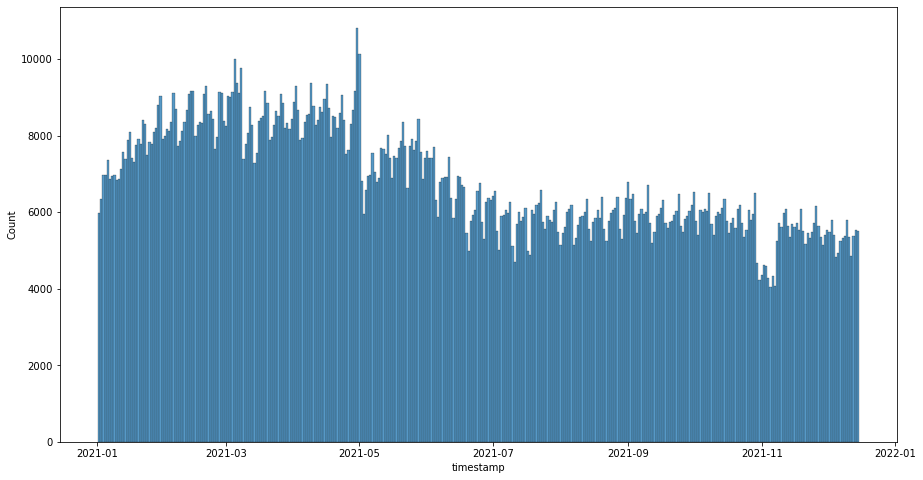

In [28]:
fig,ax = plt.subplots(figsize=(15,8))
sns.histplot(x=df['timestamp'].dt.date,ax=ax)
plt.show()


* Есть пик в районе 2021-05
* "Яма" - 2021-11

**gest_Sum**

In [29]:
describe(df['gest_Sum'])

,gest_Sum
count,2371506.000
mean,452.622
mode,201.600
var,172042.693
stddev,414.780
min,0.000
25%,195.300
50%,340.800
75%,578.200
max,23500.000


* Есть 0. Что они значат?
* Есть ~6% выборосов.

Сколько нулей?

In [30]:
df['gest_Sum'].value_counts().sort_index()[0:10]

0.000     3702
0.010        1
0.030        1
0.100       97
0.200        5
          ... 
9.700       12
9.800        2
9.800       14
9.900       14
10.000       4
Name: gest_Sum, Length: 92, dtype: int64

In [31]:
gest_Sum_zeros_count = df['gest_Sum'].value_counts().sort_index()[0]
print(f'Нулей в "gest_Sum": {gest_Sum_zeros_count}')

Нулей в "gest_Sum": 3702


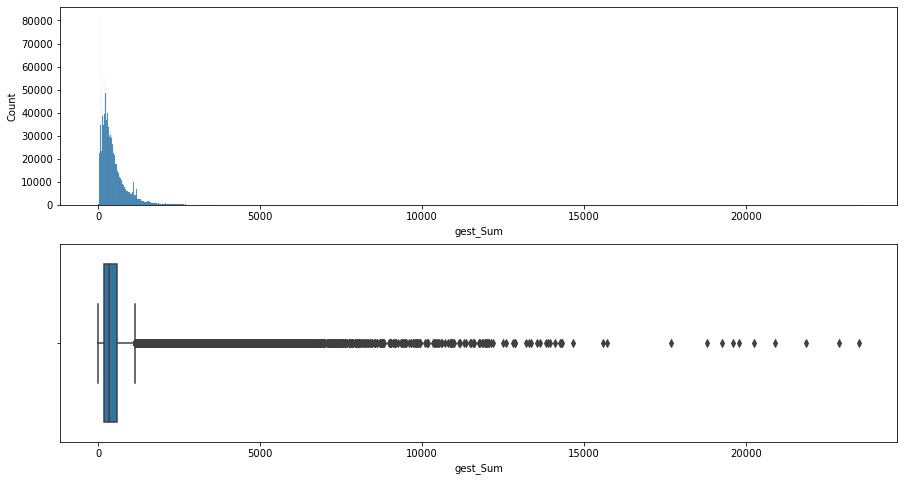

In [32]:
fig,ax = plt.subplots(2,1,figsize=(15,8))
sns.histplot(x=df['gest_Sum'],ax=ax[0],binwidth=10)
sns.boxplot(x=df['gest_Sum'],ax=ax[1])
# ax.set_xlim(0,1200)
plt.show()
# ДОБАВИТЬ НАЗВАНИЕ ГРАФИКОВ И ОСЕЙ

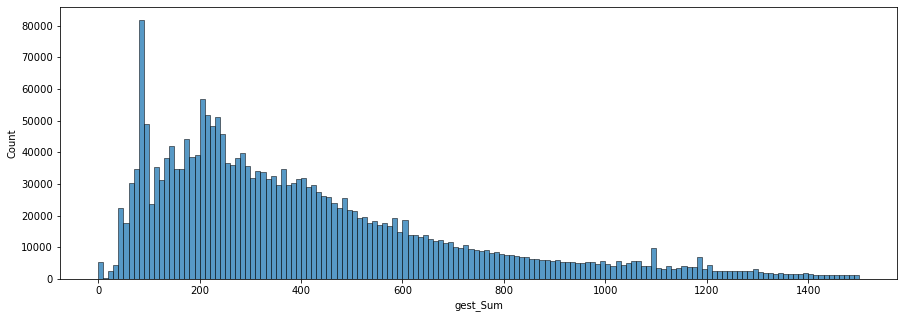

In [33]:
fig,ax = plt.subplots(1,1,figsize=(15,5))
sns.histplot(x=df['gest_Sum'],ax=ax,binwidth=10,binrange=(0,1500))

plt.show()
# ДОБАВИТЬ НАЗВАНИЕ ГРАФИКОВ И ОСЕЙ

* Есть пик в районе 100 руб. Кофе?

**gest_Discount**

In [34]:
describe(df['gest_Discount'])

,gest_Discount
count,2371506.000
mean,41.469
mode,0.000
var,7145.522
stddev,84.531
min,0.000
25%,3.100
50%,14.000
75%,44.700
max,3957.500


* Почти 10% выбросов.

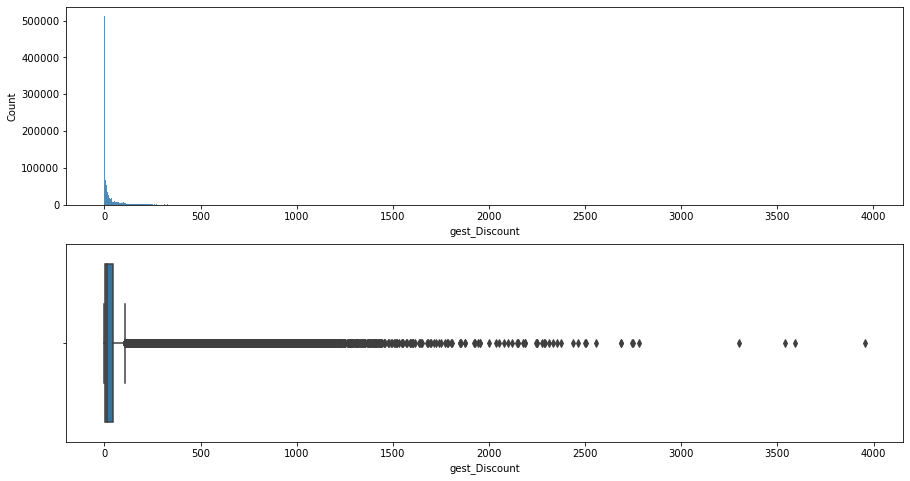

In [35]:
fig,ax = plt.subplots(2,1,figsize=(15,8))
sns.histplot(x=df['gest_Discount'],ax=ax[0],binwidth=1)
sns.boxplot(x=df['gest_Discount'],ax=ax[1])
# ax.set_xlim(0,1200)
plt.show()
# ДОБАВИТЬ НАЗВАНИЕ ГРАФИКОВ И ОСЕЙ

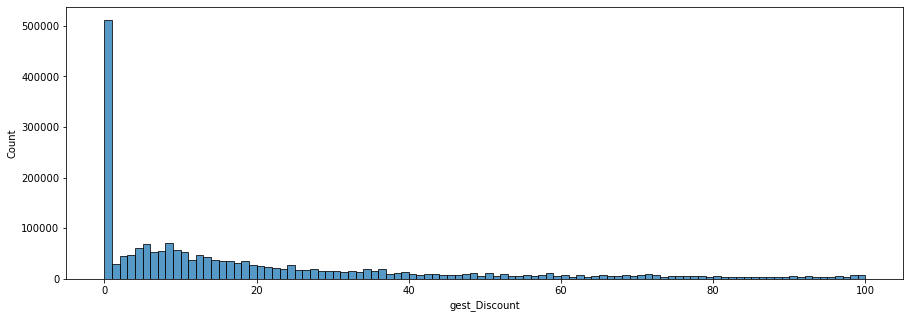

In [36]:
fig,ax = plt.subplots(1,1,figsize=(15,5))
sns.histplot(x=df['gest_Discount'],ax=ax,binwidth=1,binrange=(0,100))

plt.show()
# ДОБАВИТЬ НАЗВАНИЕ ГРАФИКОВ И ОСЕЙ

Посчитаем кол-во скидок равных 0.

In [37]:
pd.concat([df['gest_Discount'].value_counts().iloc[0:5],df['gest_Discount'].value_counts(normalize=True).iloc[0:5]],axis=1)

,gest_Discount,gest_Discount
0.000,510671,0.215
8.400,22558,0.010
9.600,18969,0.008
7.200,18342,0.008
8.800,14287,0.006


In [38]:
gest_Discount_zeros_count = df['gest_Discount'].value_counts()[0]
print(f'Кол-во нулей в "gest_Discount": {gest_Discount_zeros_count}')
gest_Discount_zeros_count = df['gest_Discount'].value_counts(normalize=True)[0]
print(f'Процентов нулей в "gest_Discount" от общего числа: {gest_Discount_zeros_count:.02%}')

Кол-во нулей в "gest_Discount": 510671
Процентов нулей в "gest_Discount" от общего числа: 21.53%


## Сравнение признаков с разделение по целевому классу

Будем сравнивать и по тому таргету, который был даден и по тому, который был сгенерирован здесь.

**Сравнение по стоимости покупки за вычетом скидки 'gest_Sum'**

In [39]:
df_eda_orig = df.merge(df_target,on='clnt_ID')
df_eda_new = df.merge(df_target_extracted,on='clnt_ID')
display(df_eda_orig.head())
df_eda_new.head()

,clnt_ID,timestamp,gest_Sum,gest_Discount,days_after_last_buy,target
0,193B4268-0B4A-475E-B1D0-FF5515E29D29,2021-01-02 09:09:17.060,900.000,300.000,-1.000,0
1,193B4268-0B4A-475E-B1D0-FF5515E29D29,2021-01-07 17:09:04.120,393.700,131.300,5.000,0
2,193B4268-0B4A-475E-B1D0-FF5515E29D29,2021-01-09 11:49:13.163,817.500,272.500,1.000,0
3,193B4268-0B4A-475E-B1D0-FF5515E29D29,2021-01-11 18:38:07.737,337.500,112.500,2.000,0
4,193B4268-0B4A-475E-B1D0-FF5515E29D29,2021-01-12 14:53:53.847,180.000,60.000,0.000,0


,clnt_ID,timestamp,gest_Sum,gest_Discount,days_after_last_buy,target_ext
0,193B4268-0B4A-475E-B1D0-FF5515E29D29,2021-01-02 09:09:17.060,900.000,300.000,-1.000,0
1,193B4268-0B4A-475E-B1D0-FF5515E29D29,2021-01-07 17:09:04.120,393.700,131.300,5.000,0
2,193B4268-0B4A-475E-B1D0-FF5515E29D29,2021-01-09 11:49:13.163,817.500,272.500,1.000,0
3,193B4268-0B4A-475E-B1D0-FF5515E29D29,2021-01-11 18:38:07.737,337.500,112.500,2.000,0
4,193B4268-0B4A-475E-B1D0-FF5515E29D29,2021-01-12 14:53:53.847,180.000,60.000,0.000,0


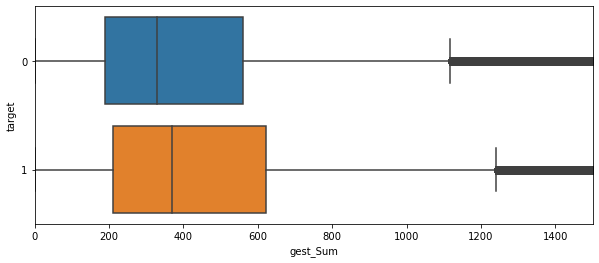

In [40]:
# По оригинальному таргету
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
sns.boxplot(x='gest_Sum', y='target', data=df_eda_orig, ax=ax,orient='h')
ax.set_xlim(0,1500)
plt.show()
# ДОБАВИТЬ НАЗВАНИЕ ГРАФИКОВ И ОСЕЙ

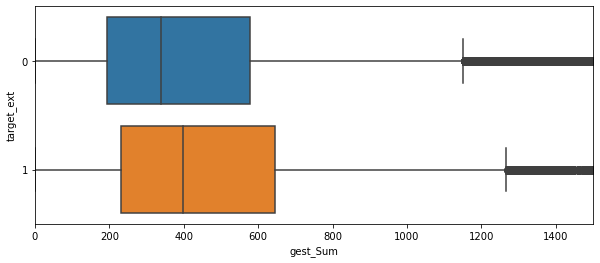

In [41]:
# По новому таргету
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
sns.boxplot(x='gest_Sum', y='target_ext', data=df_eda_new, ax=ax,orient='h')
ax.set_xlim(0,1500)
plt.show()
# ДОБАВИТЬ НАЗВАНИЕ ГРАФИКОВ И ОСЕЙ

**Сравнение по скидке 'gest_Discount'**

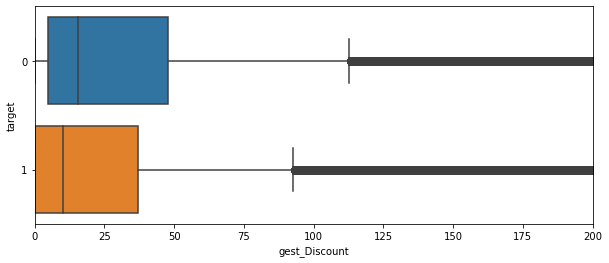

In [42]:
# По оригинальному таргету
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
sns.boxplot(x='gest_Discount', y='target', data=df_eda_orig, ax=ax,orient='h')
ax.set_xlim(0,200)
plt.show()
# ДОБАВИТЬ НАЗВАНИЕ ГРАФИКОВ И ОСЕЙ

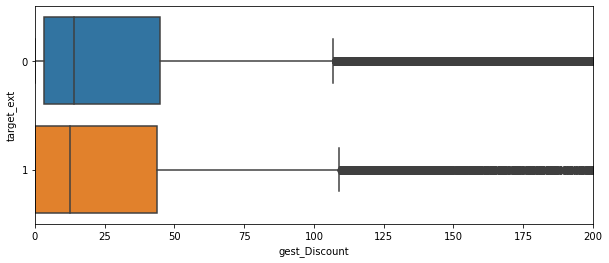

In [43]:
# По новому таргету
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
sns.boxplot(x='gest_Discount', y='target_ext', data=df_eda_new, ax=ax,orient='h')
ax.set_xlim(0,200)
plt.show()
# ДОБАВИТЬ НАЗВАНИЕ ГРАФИКОВ И ОСЕЙ

**Сравнение по общей стоимости чека ('gest_Sum'+'gest_Discount')**

Здесь нужно создать столбец с общей стоимостью чека.

In [44]:
df_eda_orig['gest_Total'] = df_eda_orig['gest_Sum'] + df_eda_orig['gest_Discount'] 
df_eda_orig.head()

,clnt_ID,timestamp,gest_Sum,gest_Discount,days_after_last_buy,target,gest_Total
0,193B4268-0B4A-475E-B1D0-FF5515E29D29,2021-01-02 09:09:17.060,900.000,300.000,-1.000,0,1200.000
1,193B4268-0B4A-475E-B1D0-FF5515E29D29,2021-01-07 17:09:04.120,393.700,131.300,5.000,0,525.000
2,193B4268-0B4A-475E-B1D0-FF5515E29D29,2021-01-09 11:49:13.163,817.500,272.500,1.000,0,1090.000
3,193B4268-0B4A-475E-B1D0-FF5515E29D29,2021-01-11 18:38:07.737,337.500,112.500,2.000,0,450.000
4,193B4268-0B4A-475E-B1D0-FF5515E29D29,2021-01-12 14:53:53.847,180.000,60.000,0.000,0,240.000


In [45]:
df_eda_new['gest_Total'] = df_eda_new['gest_Sum'] + df_eda_new['gest_Discount']
df_eda_new.head()

,clnt_ID,timestamp,gest_Sum,gest_Discount,days_after_last_buy,target_ext,gest_Total
0,193B4268-0B4A-475E-B1D0-FF5515E29D29,2021-01-02 09:09:17.060,900.000,300.000,-1.000,0,1200.000
1,193B4268-0B4A-475E-B1D0-FF5515E29D29,2021-01-07 17:09:04.120,393.700,131.300,5.000,0,525.000
2,193B4268-0B4A-475E-B1D0-FF5515E29D29,2021-01-09 11:49:13.163,817.500,272.500,1.000,0,1090.000
3,193B4268-0B4A-475E-B1D0-FF5515E29D29,2021-01-11 18:38:07.737,337.500,112.500,2.000,0,450.000
4,193B4268-0B4A-475E-B1D0-FF5515E29D29,2021-01-12 14:53:53.847,180.000,60.000,0.000,0,240.000


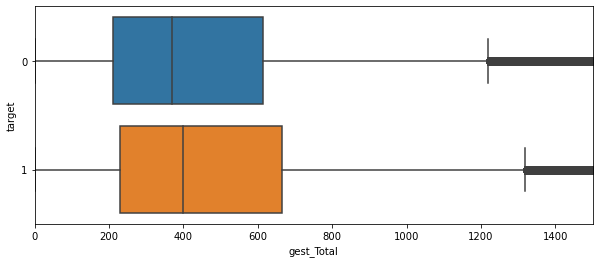

In [46]:
# По оригинальному таргету
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
sns.boxplot(x='gest_Total', y='target', data=df_eda_orig, ax=ax,orient='h')
ax.set_xlim(0,1500)
plt.show()
# ДОБАВИТЬ НАЗВАНИЕ ГРАФИКОВ И ОСЕЙ

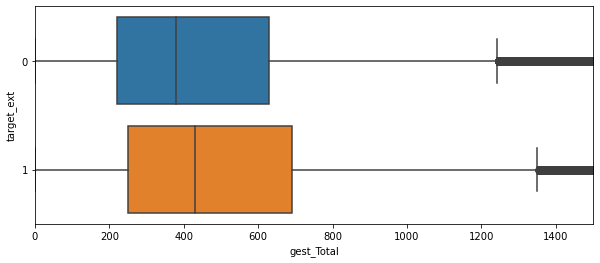

In [47]:
# По новому таргету
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
sns.boxplot(x='gest_Total', y='target_ext', data=df_eda_new, ax=ax,orient='h')
ax.set_xlim(0,1500)
plt.show()
# ДОБАВИТЬ НАЗВАНИЕ ГРАФИКОВ И ОСЕЙ

* Распределения видимо отличаются в каждых случаях.

**Сравнение зависимости gest_Sum от gest_Discount с разделем по таргету**

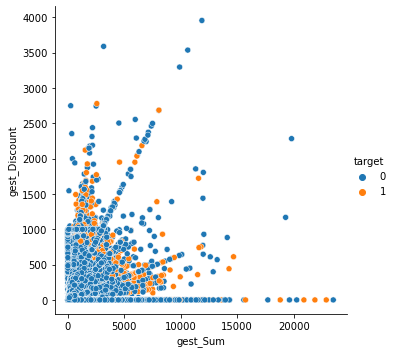

In [48]:
sns.relplot(x="gest_Sum", y="gest_Discount", hue="target", data=df_eda_orig);
# ДОБАВИТЬ НАЗВАНИЕ ГРАФИКОВ И ОСЕЙ

Похоже на то, что есть система фиксированных скидок и есть накопительные баллы или акции. Прямые линии это фиксированные скидки.

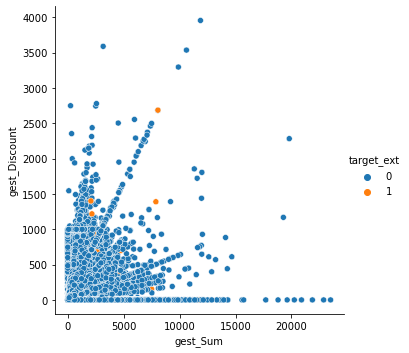

In [49]:
sns.relplot(x="gest_Sum", y="gest_Discount", hue="target_ext", data=df_eda_new);
# ДОБАВИТЬ НАЗВАНИЕ ГРАФИКОВ И ОСЕЙ

**Корреляция**

In [50]:
orig_corr = df_eda_orig.corr()
new_corr = df_eda_new.corr()

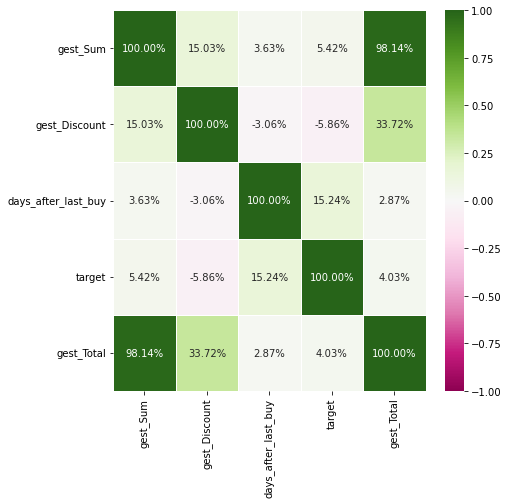

In [51]:
fig,ax = plt.subplots(figsize=(7,7))
sns.heatmap(orig_corr, annot=True,ax=ax,vmin=-1,vmax=1,linewidth=.5,cmap="PiYG",center=0,fmt='.2%')
plt.show()

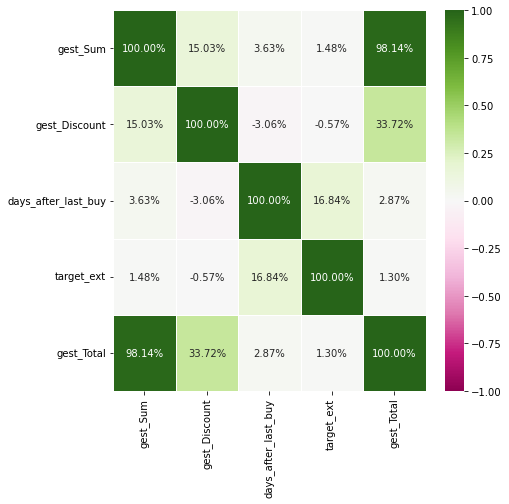

In [52]:
fig,ax = plt.subplots(figsize=(7,7))
sns.heatmap(new_corr, annot=True,ax=ax,vmin=-1,vmax=1,linewidth=.5,cmap="PiYG",center=0,fmt='.2%')
plt.show()

Чего-то особого, кроме очевидного, здесь не обнаружено.

# Feature engineering

Уже созданы:
* Кол-во дней прошедших с последней сделки (-1, если сделка первая)

Новые фичи.  
Что может помочь лучше предсказать отток клиентов? --ДОПОЛНЯЕТСЯ--

* Общая стоимость заказа без скидки
* Сколько дней на момент сделки прошло с момента первой сделки (сколько дней клиенту)
* Какой на текущий момент средний чек, средняя скидка, средний общая стоимость
* Какая разница между среднем чеком и чеком сделки
* Сколько сделок произошло на момент текущей сделки
* Сколько сделок в месяц в среднем


**Как создавать сложные фичи?**

* Нужно группировать датасет по клиентам
* К этим группам применять разные методы с помощью `.groupby().transform()`

`df.groupby('cnlt_ID').transform(func)`

**Общая стоимость заказа без скидки** = `gest_Sum + gest_Discount`

In [53]:
df['gest_Total'] = df['gest_Sum'] + df['gest_Discount']

**Сколько дней прошло с первой сделки**

1. Берем min(date)
2. Вычитаем из текущей data min(date) (`df['date'] - df['first_buy_date']`)

In [54]:
def first_buy_date_delta(col):
    return col - col.min()

df['first_buy_days_delta'] = df.groupby('clnt_ID')['timestamp'].transform(first_buy_date_delta).dt.days

In [55]:
df.tail()

,clnt_ID,timestamp,gest_Sum,gest_Discount,days_after_last_buy,gest_Total,first_buy_days_delta
2371630,6A41E569-CE78-47F3-A671-357000336B67,2021-12-15 22:27:59.033,630.000,210.000,0.000,840.000,179
2371631,9ABC36A1-BA7D-4145-A25B-609945E1B50F,2021-12-15 22:34:49.327,76.000,19.000,0.000,95.000,6
2371632,565D07CD-6B1C-4F17-988E-313C2E5C6798,2021-12-15 22:42:54.540,346.400,153.600,7.000,500.000,347
2371633,F9953B4A-FADB-4213-82EB-6E2B7D1565C7,2021-12-15 22:44:54.387,52.500,17.500,0.000,70.000,148
2371634,6E719B78-61E2-4F03-BF63-D83AE5DE5629,2021-12-15 22:45:31.087,661.600,43.400,1.000,705.000,216


**TO DO: ИЗУЧИТЬ**

In [56]:
# df['first_buy_date_delta'].dt.days.astype('int').hist(bins=100)

In [57]:
# df['first_buy_timestamp_delta'].dt.total_seconds().astype('int').hist(bins=100)

**Какой на текущий момент средний чек, средняя скидка, средний общая стоимость**

Используем `series.expanding().mean()` через `df.groupby('clnt_ID').transform()`.

In [58]:
def expand_mean(col):
    return col.expanding().mean()
df['clnt_gest_Sum_avg_ongoing'] = df.groupby('clnt_ID')['gest_Sum'].transform(expand_mean)
df['clnt_gest_Discount_avg_ongoing'] = df.groupby('clnt_ID')['gest_Discount'].transform(expand_mean)
df['clnt_gest_Total_avg_ongoing'] = df.groupby('clnt_ID')['gest_Total'].transform(expand_mean)

In [59]:
df.head()

,clnt_ID,timestamp,gest_Sum,gest_Discount,days_after_last_buy,gest_Total,first_buy_days_delta,clnt_gest_Sum_avg_ongoing,clnt_gest_Discount_avg_ongoing,clnt_gest_Total_avg_ongoing
0,193B4268-0B4A-475E-B1D0-FF5515E29D29,2021-01-02 09:09:17.060,900.000,300.000,-1.000,1200.000,0,900.000,300.000,1200.000
1,8DA65A37-C1D0-41D4-98E1-AB6C5BF1367F,2021-01-02 09:12:24.850,165.000,55.000,-1.000,220.000,0,165.000,55.000,220.000
2,26ACF3C8-25C8-4345-ABC2-33DA15EA6454,2021-01-02 09:38:21.643,800.500,25.500,-1.000,826.000,0,800.500,25.500,826.000
3,0F77DDB3-A9A7-44BE-AAAB-9DF59B66A695,2021-01-02 09:45:17.793,580.000,0.000,-1.000,580.000,0,580.000,0.000,580.000
4,F16BCF77-FA5A-4093-B7E3-FA86E2B1EA31,2021-01-02 09:59:50.453,148.900,3.100,-1.000,152.000,0,148.900,3.100,152.000


**TO DO: ИЗУЧИТЬ**

In [60]:
# df['clnt_gest_Sum_avg'].hist(bins=100)

**Какая разница между средним значением и значением сделки**
Считаем для:
* 'gest_Sum'
* 'gest_Discount'
* 'gest_Total'

`df['gest_Sum'] - df['clnt_gest_Sum_avg_ongoing']`  
`df['gest_Discount'] - df['clnt_gest_Discount_avg_ongoing']`  
`df['gest_Total'] - df['clnt_gest_total_avg_ongoing']`

In [61]:
df['gest_Sum_delta_from_avg'] = df['gest_Sum'] - df['clnt_gest_Sum_avg_ongoing']
df['gest_Discount_delta_from_avg'] = df['gest_Discount'] - df['clnt_gest_Discount_avg_ongoing']
df['gest_total_delta_from_avg'] = df['gest_Total'] - df['clnt_gest_Total_avg_ongoing']

In [62]:
df.tail()

,clnt_ID,timestamp,gest_Sum,gest_Discount,days_after_last_buy,gest_Total,first_buy_days_delta,clnt_gest_Sum_avg_ongoing,clnt_gest_Discount_avg_ongoing,clnt_gest_Total_avg_ongoing,gest_Sum_delta_from_avg,gest_Discount_delta_from_avg,gest_total_delta_from_avg
2371630,6A41E569-CE78-47F3-A671-357000336B67,2021-12-15 22:27:59.033,630.000,210.000,0.000,840.000,179,315.499,107.403,422.901,314.501,102.597,417.099
2371631,9ABC36A1-BA7D-4145-A25B-609945E1B50F,2021-12-15 22:34:49.327,76.000,19.000,0.000,95.000,6,499.400,42.200,541.600,-423.400,-23.200,-446.600
2371632,565D07CD-6B1C-4F17-988E-313C2E5C6798,2021-12-15 22:42:54.540,346.400,153.600,7.000,500.000,347,260.295,86.646,346.942,86.105,66.954,153.058
2371633,F9953B4A-FADB-4213-82EB-6E2B7D1565C7,2021-12-15 22:44:54.387,52.500,17.500,0.000,70.000,148,369.185,159.875,529.060,-316.685,-142.375,-459.060
2371634,6E719B78-61E2-4F03-BF63-D83AE5DE5629,2021-12-15 22:45:31.087,661.600,43.400,1.000,705.000,216,374.905,36.231,411.136,286.695,7.169,293.864


**TO DO: ИЗУЧИТЬ**

In [63]:
# df['gest_total_delta_from_avg'].hist(bins=100)

**Сколько сделок произошло на момент текущей сделки**  
`series.expanding().count()`

In [64]:
def expand_count(col):
    return col.expanding().count()

df['clnt_buys_count'] = df.groupby('clnt_ID')['timestamp'].transform(expand_count)

In [65]:
df.tail()

,clnt_ID,timestamp,gest_Sum,gest_Discount,days_after_last_buy,gest_Total,first_buy_days_delta,clnt_gest_Sum_avg_ongoing,clnt_gest_Discount_avg_ongoing,clnt_gest_Total_avg_ongoing,gest_Sum_delta_from_avg,gest_Discount_delta_from_avg,gest_total_delta_from_avg,clnt_buys_count
2371630,6A41E569-CE78-47F3-A671-357000336B67,2021-12-15 22:27:59.033,630.000,210.000,0.000,840.000,179,315.499,107.403,422.901,314.501,102.597,417.099,334.000
2371631,9ABC36A1-BA7D-4145-A25B-609945E1B50F,2021-12-15 22:34:49.327,76.000,19.000,0.000,95.000,6,499.400,42.200,541.600,-423.400,-23.200,-446.600,5.000
2371632,565D07CD-6B1C-4F17-988E-313C2E5C6798,2021-12-15 22:42:54.540,346.400,153.600,7.000,500.000,347,260.295,86.646,346.942,86.105,66.954,153.058,249.000
2371633,F9953B4A-FADB-4213-82EB-6E2B7D1565C7,2021-12-15 22:44:54.387,52.500,17.500,0.000,70.000,148,369.185,159.875,529.060,-316.685,-142.375,-459.060,117.000
2371634,6E719B78-61E2-4F03-BF63-D83AE5DE5629,2021-12-15 22:45:31.087,661.600,43.400,1.000,705.000,216,374.905,36.231,411.136,286.695,7.169,293.864,176.000


**TO DO: ИЗУЧИТЬ**

In [66]:
# df['clnt_buys_count'].describe()

In [67]:
# df['clnt_buys_count'].hist(bins=100)

# BASELINE и model selection

Для бейслайна используем данные в таком виде:
* Группируем по клиенту,
* берем общее число покупок
* мин, макс, медиана, среднее, стд отклонение по `gest_Sum`, `gest_Discount`, 
* кол-во дней между покупками, медиана, среднее, стд. отклонение.

Модели:
* логистическая регрессия
* дерево решений
* случайный лес

Оцениваем `roc auc` по кроссвалидации на 5 фолдах.

Проверим на всякий случай по оригинальному и новому таргету.

In [68]:
# Скопируем датасет
df_baseline = df.copy()
df_baseline = df_baseline.drop(columns=['timestamp'])
df_baseline.head()

,clnt_ID,gest_Sum,gest_Discount,days_after_last_buy,gest_Total,first_buy_days_delta,clnt_gest_Sum_avg_ongoing,clnt_gest_Discount_avg_ongoing,clnt_gest_Total_avg_ongoing,gest_Sum_delta_from_avg,gest_Discount_delta_from_avg,gest_total_delta_from_avg,clnt_buys_count
0,193B4268-0B4A-475E-B1D0-FF5515E29D29,900.000,300.000,-1.000,1200.000,0,900.000,300.000,1200.000,0.000,0.000,0.000,1.000
1,8DA65A37-C1D0-41D4-98E1-AB6C5BF1367F,165.000,55.000,-1.000,220.000,0,165.000,55.000,220.000,0.000,0.000,0.000,1.000
2,26ACF3C8-25C8-4345-ABC2-33DA15EA6454,800.500,25.500,-1.000,826.000,0,800.500,25.500,826.000,0.000,0.000,0.000,1.000
3,0F77DDB3-A9A7-44BE-AAAB-9DF59B66A695,580.000,0.000,-1.000,580.000,0,580.000,0.000,580.000,0.000,0.000,0.000,1.000
4,F16BCF77-FA5A-4093-B7E3-FA86E2B1EA31,148.900,3.100,-1.000,152.000,0,148.900,3.100,152.000,0.000,0.000,0.000,1.000


In [69]:
# Создадим словарь для функция агрегирования по необходимым столбцам
aggfunc_dict = {'gest_Sum': ['min','max','median','mean','std'], 
                'gest_Discount': ['min','max','median','mean','std'], 
                'clnt_buys_count': ['max','median','mean','std']} # здесь min не нужен, т.к. везде будут 1

In [70]:
# Сгруппируем по клиентам применим агрегирующие функции из словаря
pivot_baseline = df_baseline.pivot_table(index='clnt_ID', values=['gest_Sum','gest_Discount','clnt_buys_count'],aggfunc=aggfunc_dict, 
                                         fill_value=0 # Пропуски будут в стандартном отклонении любых признаков, где только 1 покупка
                                        )

In [71]:
# Уберем мульти-уровни в столбцах
pivot_baseline.columns = ['_'.join(column) for column in pivot_baseline.columns]

In [72]:
pivot_baseline.describe()

,clnt_buys_count_max,clnt_buys_count_mean,clnt_buys_count_median,clnt_buys_count_std,gest_Discount_max,gest_Discount_mean,gest_Discount_median,gest_Discount_min,gest_Discount_std,gest_Sum_max,gest_Sum_mean,gest_Sum_median,gest_Sum_min,gest_Sum_std
count,255109.000,255109.000,255109.000,255109.000,255109.000,255109.000,255109.000,255109.000,255109.000,255109.000,255109.000,255109.000,255109.000,255109.000
mean,9.296,5.148,5.148,2.645,96.011,46.174,40.298,30.937,21.568,885.385,609.003,586.838,449.685,161.768
std,23.156,11.578,11.578,6.752,185.499,138.910,139.234,137.689,46.447,724.995,538.335,543.737,553.309,244.786
min,1.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,1.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,408.900,295.000,268.000,118.000,0.000
50%,2.000,1.500,1.500,0.707,26.800,11.213,0.000,0.000,0.000,728.000,470.171,438.000,260.000,77.737
75%,6.000,3.500,3.500,1.871,103.400,39.200,26.400,5.200,29.506,1189.000,760.000,737.500,582.000,254.650
max,1314.000,657.500,657.500,379.463,3957.500,2780.500,2780.500,2780.500,1463.401,23500.000,23500.000,23500.000,23500.000,15247.626


In [73]:
# Создадим два датафрейма с присоединенными таргетами (оригинальным и новым)
pivot_baseline_full_orig = pivot_baseline.merge(df_target,on='clnt_ID')
pivot_baseline_full_new = pivot_baseline.merge(df_target_extracted,on='clnt_ID').reset_index()

In [74]:
pivot_baseline_full_orig.head()

,clnt_ID,clnt_buys_count_max,clnt_buys_count_mean,clnt_buys_count_median,clnt_buys_count_std,gest_Discount_max,gest_Discount_mean,gest_Discount_median,gest_Discount_min,gest_Discount_std,gest_Sum_max,gest_Sum_mean,gest_Sum_median,gest_Sum_min,gest_Sum_std,target
0,000070A8-DB9E-4AB7-8C4D-6169D4AEBB2A,3,2.000,2.000,1.000,44.800,21.800,10.600,10.000,19.921,566.200,525.200,519.400,490.000,38.430,1
1,00007EB0-6331-438E-A917-E9840C260876,1,1.000,1.000,0.000,6.000,6.000,6.000,6.000,0.000,214.000,214.000,214.000,214.000,0.000,0
2,0000993D-A30E-4233-AB3F-D368D9A0D2C4,1,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,470.000,470.000,470.000,470.000,0.000,1
3,0000A724-7BC5-408F-9F16-6CC3AB16322F,64,32.500,32.500,18.619,280.800,31.162,8.550,0.000,62.320,562.600,274.228,260.550,0.000,118.275,0
4,0000B90C-56DE-43C2-A213-624AFBE36DB2,1,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,549.000,549.000,549.000,549.000,0.000,0


In [75]:
pivot_baseline_full_new.head()

,clnt_ID,clnt_buys_count_max,clnt_buys_count_mean,clnt_buys_count_median,clnt_buys_count_std,gest_Discount_max,gest_Discount_mean,gest_Discount_median,gest_Discount_min,gest_Discount_std,gest_Sum_max,gest_Sum_mean,gest_Sum_median,gest_Sum_min,gest_Sum_std,target_ext
0,000070A8-DB9E-4AB7-8C4D-6169D4AEBB2A,3,2.000,2.000,1.000,44.800,21.800,10.600,10.000,19.921,566.200,525.200,519.400,490.000,38.430,0
1,00007EB0-6331-438E-A917-E9840C260876,1,1.000,1.000,0.000,6.000,6.000,6.000,6.000,0.000,214.000,214.000,214.000,214.000,0.000,0
2,0000993D-A30E-4233-AB3F-D368D9A0D2C4,1,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,470.000,470.000,470.000,470.000,0.000,0
3,0000A724-7BC5-408F-9F16-6CC3AB16322F,64,32.500,32.500,18.619,280.800,31.162,8.550,0.000,62.320,562.600,274.228,260.550,0.000,118.275,0
4,0000B90C-56DE-43C2-A213-624AFBE36DB2,1,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,549.000,549.000,549.000,549.000,0.000,0


In [76]:
# Уберем айдишники клиентов. Модели они только помешают
pivot_baseline_full_orig = pivot_baseline_full_orig.drop(columns=['clnt_ID'])
pivot_baseline_full_new = pivot_baseline_full_new.drop(columns=['clnt_ID'])


In [77]:
# Создадим фичи и таргет

# Оригинальный
X_orig = pivot_baseline_full_orig.drop(columns=['target'])
y_orig = pivot_baseline_full_orig['target']

# Новый
X_new = pivot_baseline_full_new.drop(columns=['target_ext'])
y_new = pivot_baseline_full_new['target_ext']

In [78]:
display(X_orig.head())
y_orig.head()

,clnt_buys_count_max,clnt_buys_count_mean,clnt_buys_count_median,clnt_buys_count_std,gest_Discount_max,gest_Discount_mean,gest_Discount_median,gest_Discount_min,gest_Discount_std,gest_Sum_max,gest_Sum_mean,gest_Sum_median,gest_Sum_min,gest_Sum_std
0,3,2.000,2.000,1.000,44.800,21.800,10.600,10.000,19.921,566.200,525.200,519.400,490.000,38.430
1,1,1.000,1.000,0.000,6.000,6.000,6.000,6.000,0.000,214.000,214.000,214.000,214.000,0.000
2,1,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,470.000,470.000,470.000,470.000,0.000
3,64,32.500,32.500,18.619,280.800,31.162,8.550,0.000,62.320,562.600,274.228,260.550,0.000,118.275
4,1,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,549.000,549.000,549.000,549.000,0.000


0    1
1    0
2    1
3    0
4    0
Name: target, dtype: int64

In [79]:
display(X_new.head())
y_new.head()

,clnt_buys_count_max,clnt_buys_count_mean,clnt_buys_count_median,clnt_buys_count_std,gest_Discount_max,gest_Discount_mean,gest_Discount_median,gest_Discount_min,gest_Discount_std,gest_Sum_max,gest_Sum_mean,gest_Sum_median,gest_Sum_min,gest_Sum_std
0,3,2.000,2.000,1.000,44.800,21.800,10.600,10.000,19.921,566.200,525.200,519.400,490.000,38.430
1,1,1.000,1.000,0.000,6.000,6.000,6.000,6.000,0.000,214.000,214.000,214.000,214.000,0.000
2,1,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,470.000,470.000,470.000,470.000,0.000
3,64,32.500,32.500,18.619,280.800,31.162,8.550,0.000,62.320,562.600,274.228,260.550,0.000,118.275
4,1,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,549.000,549.000,549.000,549.000,0.000


0    0
1    0
2    0
3    0
4    0
Name: target_ext, dtype: int8

In [80]:
# Логистическая регрессия
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    log_reg = LogisticRegression()
    log_reg_cv_orig = cross_validate(log_reg, X_orig, y_orig, cv=5, scoring='roc_auc')
    log_reg_cv_new = cross_validate(log_reg, X_new, y_new, cv=5, scoring='roc_auc')
    
# Здесь ошибки несходимости - убрал

In [81]:
# Дерево решений
tree = DecisionTreeClassifier()
tree_cv_orig = cross_validate(tree,X_orig,y_orig,cv=5,scoring='roc_auc')
tree_cv_new = cross_validate(tree,X_new,y_new,cv=5,scoring='roc_auc')

In [82]:
# Случайный лес
forest = RandomForestClassifier()
forest_cv_orig = cross_validate(forest,X_orig,y_orig,cv=5,scoring='roc_auc')
forest_cv_new = cross_validate(forest,X_new,y_new,cv=5,scoring='roc_auc')

In [83]:
# Подсчет и вывод метрик

# Оригинальный
lr_roc_auc_orig = log_reg_cv_orig['test_score'].mean()
tree_roc_auc_orig = tree_cv_orig['test_score'].mean()
forest_roc_auc_orig = forest_cv_orig['test_score'].mean()

# Новый
lr_roc_auc_new = log_reg_cv_new['test_score'].mean()
tree_roc_auc_new = tree_cv_new['test_score'].mean()
forest_roc_auc_new = forest_cv_new['test_score'].mean()

scores = {'ORIG logreg roc auc': lr_roc_auc_orig,
         'ORIG tree roc auc': tree_roc_auc_orig,
         'ORIG forest roc auc': forest_roc_auc_orig,
         'NEW logreg roc auc': lr_roc_auc_new,
         'NEW tree roc auc': tree_roc_auc_new,
         'NEW forest roc auc': forest_roc_auc_new}

for key,value in scores.items():
    print(f'{key} {value:.03f}')

ORIG logreg roc auc 0.669
ORIG tree roc auc 0.617
ORIG forest roc auc 0.707
NEW logreg roc auc 0.619
NEW tree roc auc 0.513
NEW forest roc auc 0.721


В обоих случаях лучше всего себя показывает случайный лес.

### catboost -- ON HOLD

In [84]:
# ON HOLD

# test_data = catboost_pool = Pool(train_data, 
#                                  train_labels)

# model = CatBoostClassifier(iterations=2,
#                            depth=2,
#                            learning_rate=1,
#                            loss_function='Logloss',
#                            verbose=True)
# # train the model
# model.fit(train_data, train_labels)
# # make the prediction using the resulting model
# preds_class = model.predict(test_data)
# preds_proba = model.predict_proba(test_data)
# print("class = ", preds_class)
# print("proba = ", preds_proba)

# Model tuning

EMPTY